In [1]:
import numpy as np
import matplotlib.pylab as plt
import copy

import apoc
import pyclesperanto_prototype as cle
import napari
import tifffile

C:\Users\naly008c\.conda\envs\axolotl\Lib\site-packages\pytools\persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


In [2]:
from image_analysis.read_files import get_paths, change_paths
from image_analysis.preprocess import mask

# GPU device

In [3]:
device = cle.get_device()
print("Device name:", device.name)

Device name: Intel(R) UHD Graphics 620


# Information about the image

In [4]:
channels = {
            "fgf":    0, 
            "shh":    1, 
            "bright": 2, 
            "dapi":   3, 
            "dusp":   4, 
            "auto":   5
           }


# Voxel size
pixel_size_x, pixel_size_y, pixel_size_z = 2*0.9019, 2*0.9019, 2*3.9991

# Fixed values for image preprocessing

In [5]:
downsample = 2  # downsampling level while image loading (the same along all axis)
sigma = 5 * downsample * pixel_size_x /2     # for gauss filter before thresholding
print(sigma)

9.019


# Load image

In [6]:
image_folder_tif = r'example_raw_images/'
sample = '2_5cm_6dpa_noif'

img_paths = get_paths(image_folder_tif, channel='6d',suffix='tif')
img_paths = change_paths(img_paths, include='noif')

In [7]:
img_paths = sorted(
    img_paths,
    key = lambda c: c.split('/c')[1].split('_')[0]
)

In [8]:
img_paths

['example_raw_images/c1_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c2_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c3_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c4_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c5_hcr21_20240722_6d_noif.tif',
 'example_raw_images/c6_hcr21_20240722_6d_noif.tif']

In [9]:
img = []
for path in img_paths:
    i = tifffile.imread(path)
    img.append(i[::downsample, ::downsample, ::downsample])
img = np.array(img).astype( np.uint16 )

channels = list(channels.keys())
img = dict(zip(channels, img))

In [10]:
del img['dapi']
del img['bright']
del img['auto']

In [11]:
for key in img.keys():
    img[key] = np.flip(img[key], 2)
    # take 2d slice
    mid_slice = img[key].shape[0] // 2
    img[key] = img[key][mid_slice]

# Plot channels

In [12]:
pixel_size_x, pixel_size_y = downsample*pixel_size_x, downsample*pixel_size_y

In [13]:
height, width = img['dusp'].shape
extent = [0, width * pixel_size_x, height * pixel_size_y, 0]  # Flip y-axis to keep origin at top-left

In [14]:
import matplotlib.cm as cm
import matplotlib
import matplotlib.colors as mcolors

def modified_cmap(base_cmap_name):
    cmap = matplotlib.colormaps[base_cmap_name]
    new_cmap = cmap(np.linspace(0, 1, 256))
    new_cmap[0] = [1, 1, 1, 1]  # Force zero to be white (RGBA)
    return mcolors.ListedColormap(new_cmap)

# Define modified color maps
color_map = {
    'fgf': modified_cmap('Blues'),
    'shh': modified_cmap('Reds'),
    'dusp': modified_cmap('Purples'),
    'tissue_mask': modified_cmap('Greys'), 
    'kernel': modified_cmap('Greys'), # Notice the correct spelling for matplotlib
}

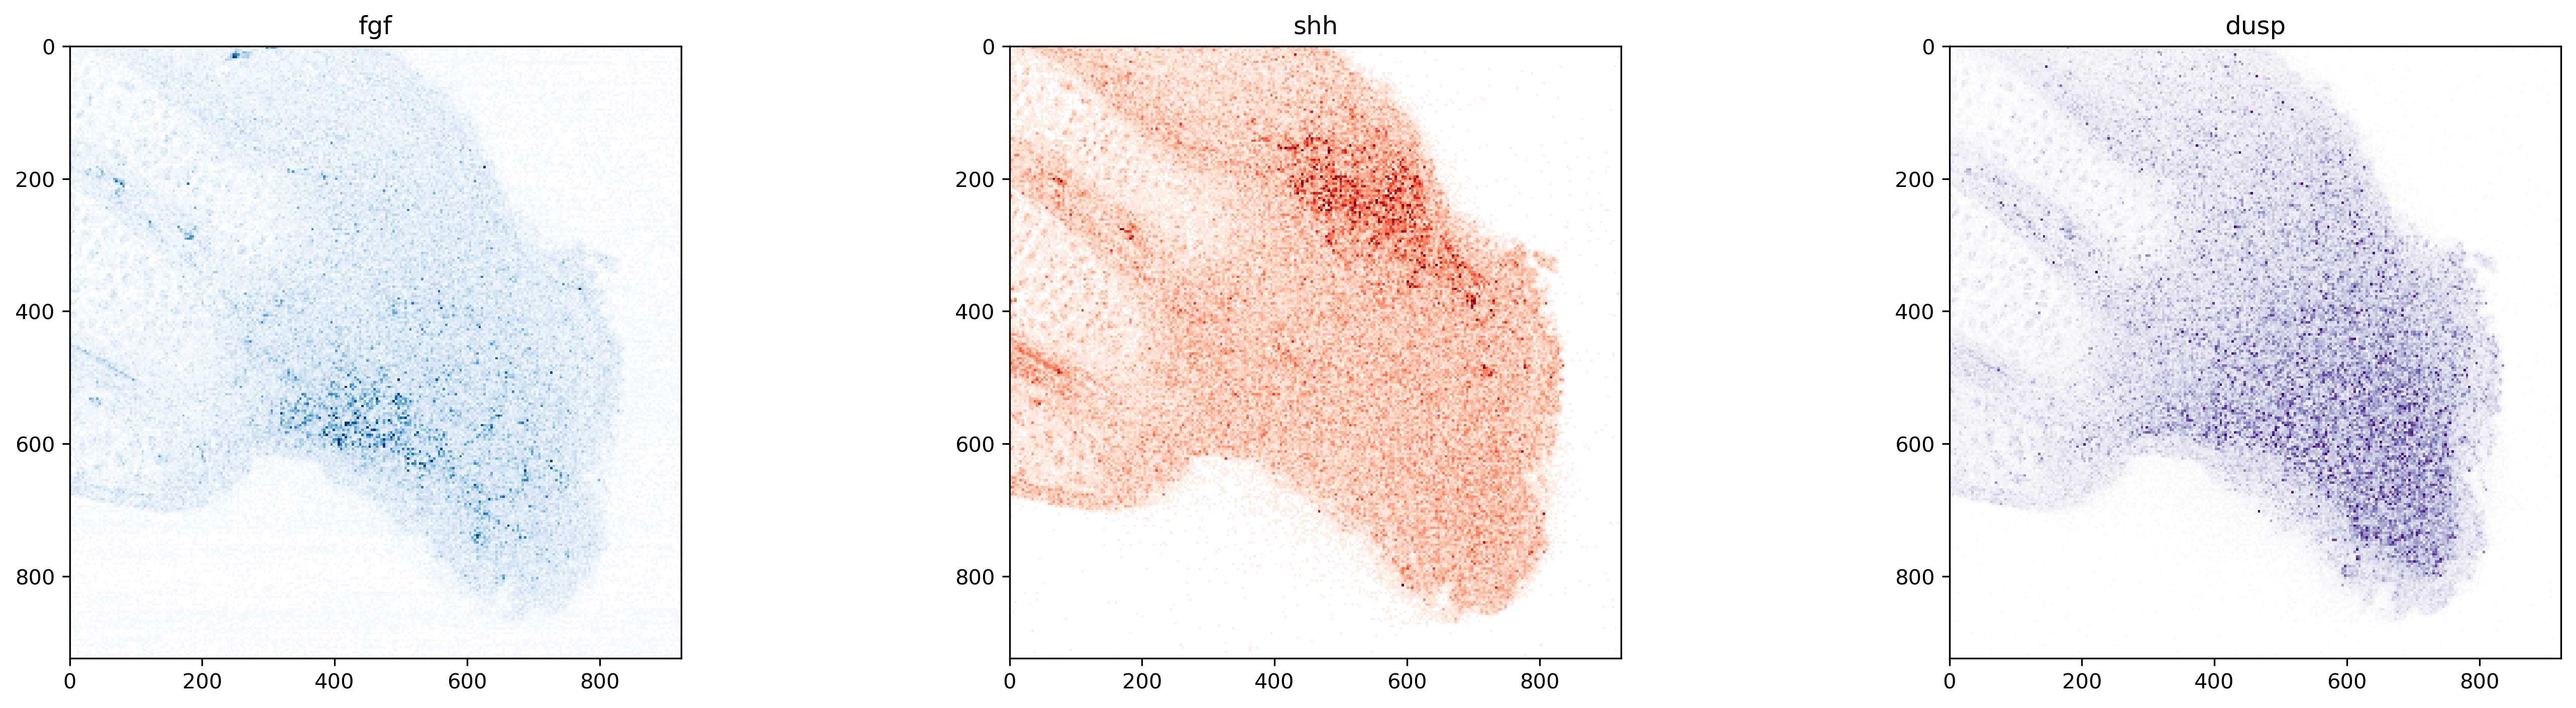

In [15]:
# Plotting
default_figsize = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, len(img), figsize=(default_figsize[0] * len(img), default_figsize[1]), dpi=300)

if len(img) == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, (key, image) in zip(axes, img.items()):
    ax.imshow(2*image, cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(key)

plt.tight_layout()
#plt.savefig('fig/channels.pdf')
plt.show()

# APOC segmenter for tissue mask

In [16]:
manual_annotations = tifffile.imread('segmenters/manual_annotations_for_tissue_mask_2_5cm_6dpa_noif.tif')

In [17]:
# define features (standart)
features = apoc.PredefinedFeatureSet.small_quick.value

# this is where the model will be saved
cl_filename = "segmenters/tissue_mask_2_5cm.cl"

apoc.erase_classifier(cl_filename)
clf = apoc.ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, manual_annotations, img['dusp'])

C:\Users\naly008c\.conda\envs\axolotl\Lib\site-packages\pyclesperanto_prototype\_tier9\_imshow.py:35: UserWarning: cle.imshow is deprecated, use stackview.imshow instead.
  warnings.warn("cle.imshow is deprecated, use stackview.imshow instead.")


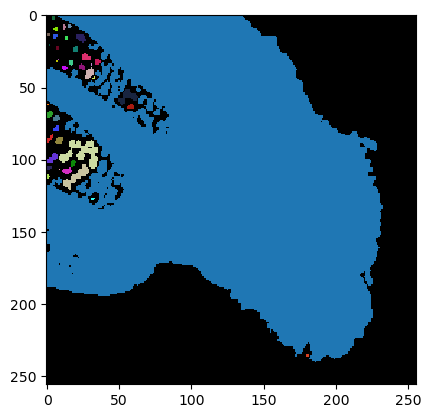

In [18]:
segmentation_result = clf.predict(features=features, image=img['dusp'])
cle.imshow(segmentation_result, labels=True)

In [19]:
tissue_mask = np.array( segmentation_result > 0 ).astype( np.uint16 )

In [20]:
from scipy import ndimage
import skimage 

tissue_mask[0, :] = 1
tissue_mask[:, 0] = 1

tissue_mask = ndimage.binary_fill_holes(tissue_mask)

r = 5
selem = skimage.morphology.disk(radius=r)
# Apply binary opening
tissue_mask = skimage.morphology.binary_opening(tissue_mask, selem)
        
# Apply binary closing
tissue_mask = skimage.morphology.binary_closing(tissue_mask, selem)

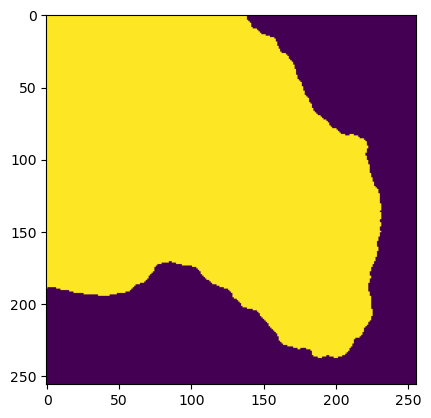

In [21]:
plt.imshow( tissue_mask )

In [22]:
img['tissue_mask'] = tissue_mask

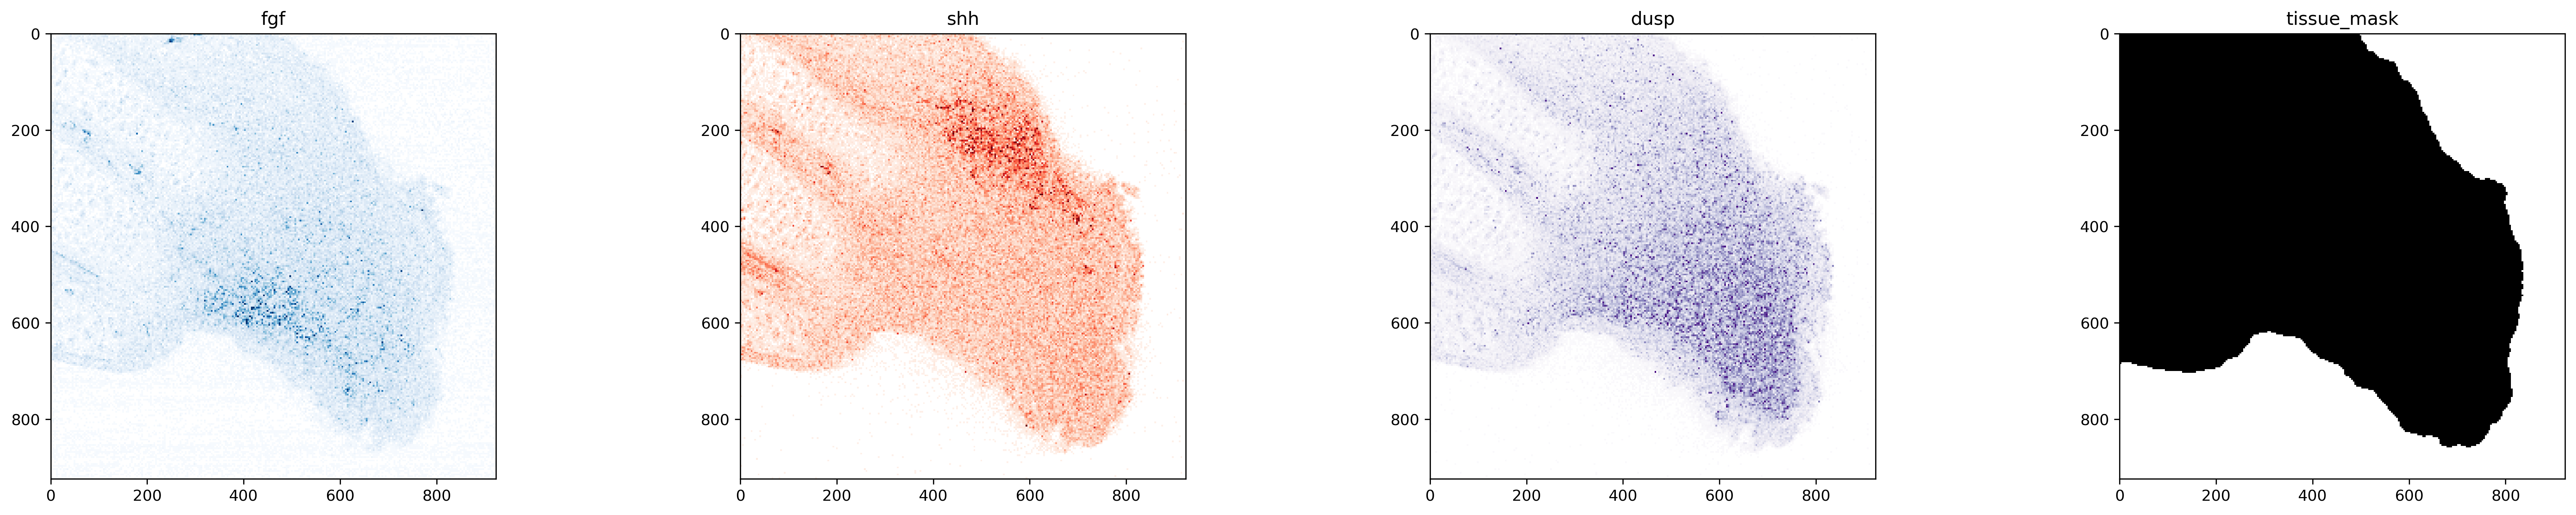

In [23]:
# Plotting
default_figsize = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, len(img), figsize=(default_figsize[0] * len(img), default_figsize[1]), dpi=300)

if len(img) == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, (key, image) in zip(axes, img.items()):
    ax.imshow(2*image, cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(key)

plt.tight_layout()
#plt.savefig('fig/channels.pdf')
plt.show()

# Epidermis mask

In [24]:
from scipy.ndimage import binary_erosion

# manually define epidermis thickness in pixels
thickness = 9

inner = binary_erosion(img['tissue_mask'], iterations=thickness)
img['epidermis_mask'] = img['tissue_mask'] & (~inner)

img['tissue_mask_with_epi'] = copy.deepcopy(img['tissue_mask'])
img['tissue_mask']          = img['tissue_mask'] * mask.invert(img['epidermis_mask'])

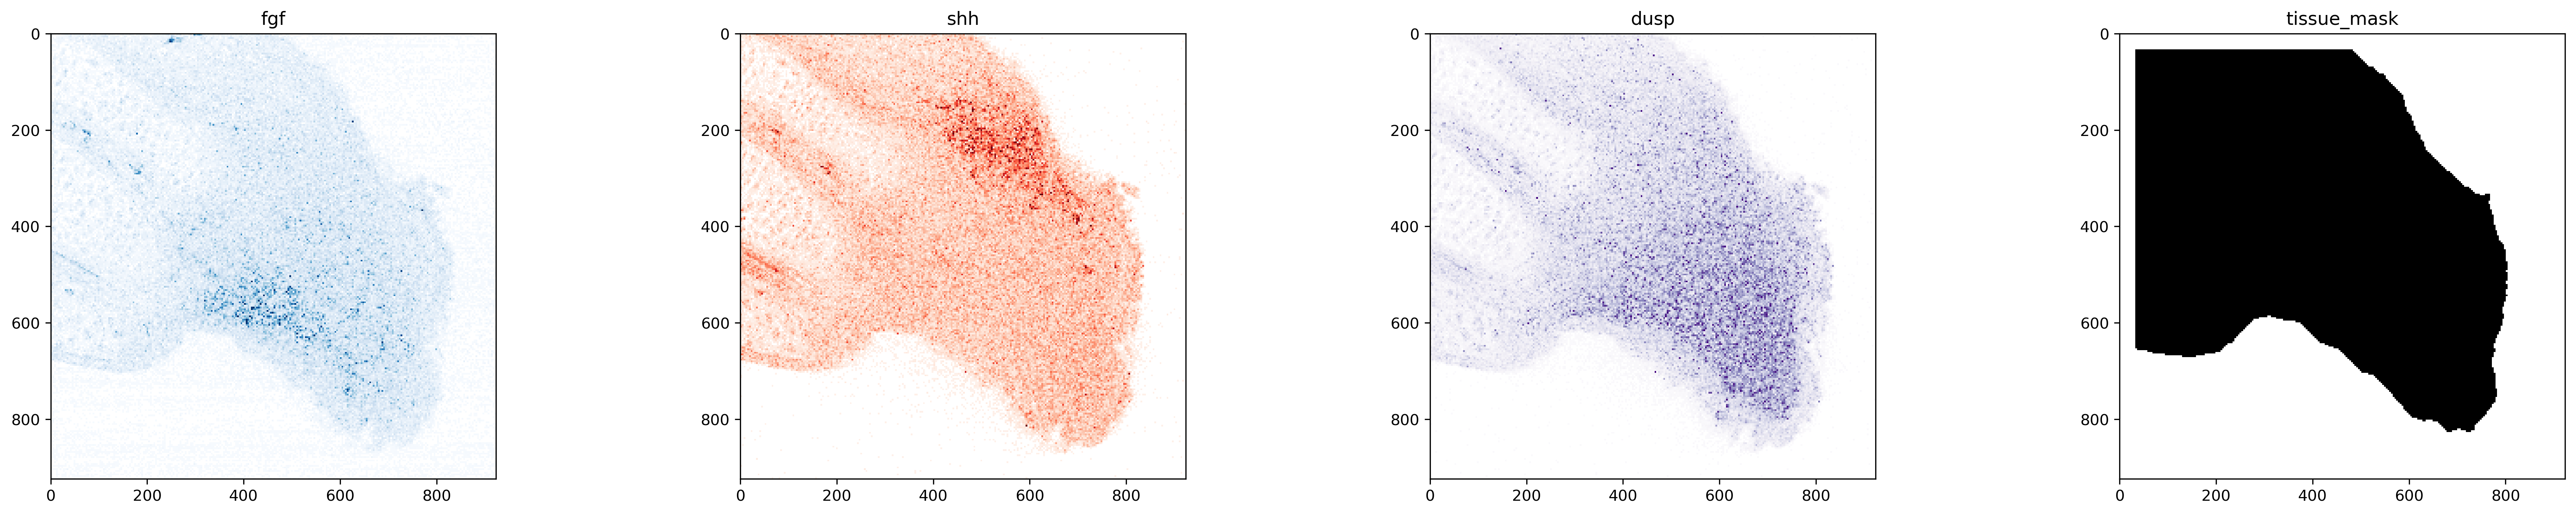

In [25]:
selected_keys = ['fgf', 'shh', 'dusp', 'tissue_mask']  # your selected keys
img_plot = {key: img[key] for key in selected_keys if key in img}

# Plotting
default_figsize = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, len(img_plot), figsize=(default_figsize[0] * len(img_plot), default_figsize[1]), dpi=300)

if len(img_plot) == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, (key, image) in zip(axes, img_plot.items()):
    ax.imshow(2*image, cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(key)

plt.tight_layout()
#plt.savefig('fig/channels.pdf')
plt.show()

# Substruct background

In [26]:
selected_keys = ['fgf', 'shh', 'dusp', 'tissue_mask']  # your selected keys
img_wo_bg = {key: img[key] for key in selected_keys if key in img}

In [27]:
mask_inverted = mask.invert(img['tissue_mask'])

for key in img_wo_bg.keys():
    if key.find('mask') < 0:
        bg = mask_inverted * img_wo_bg[key]
        if np.any(bg != 0):
            bg = np.mean(bg[np.where(bg != 0)])
        else:
            bg = 0
        print(f'Mean background value = {bg}')

        image_wo_bg = (img_wo_bg[key] - bg) * img['tissue_mask']
        image_wo_bg[np.where(img_wo_bg[key] < bg)] = 0
        img_wo_bg[key] = image_wo_bg.astype(np.uint16)

Mean background value = 772.0228394842468
Mean background value = 4167.410595223663
Mean background value = 3121.4536612021857


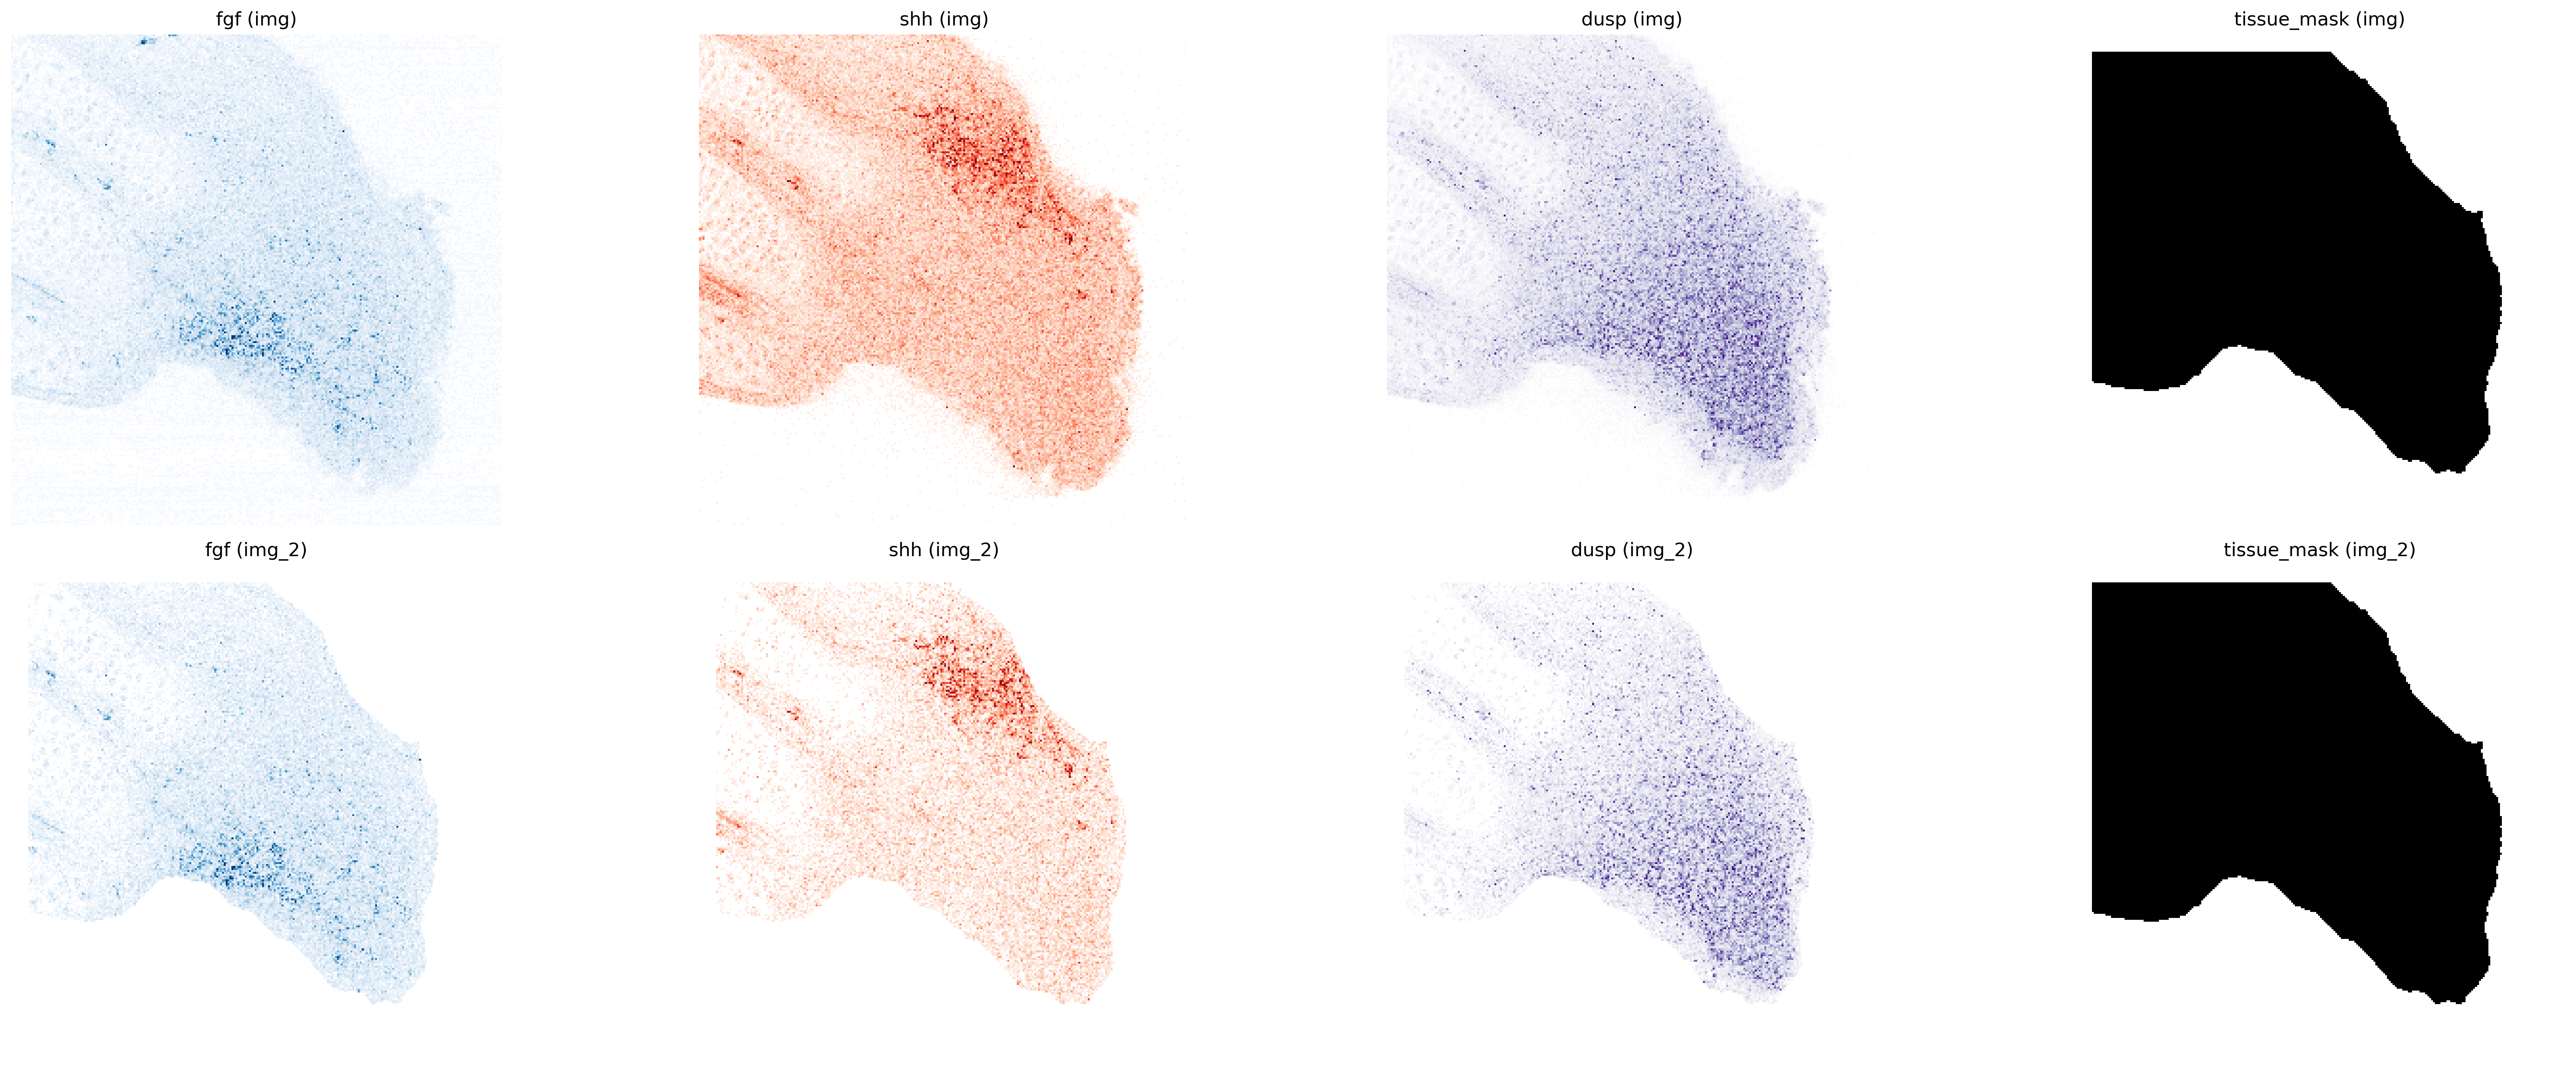

In [28]:
# Plotting
default_figsize = plt.rcParams["figure.figsize"]
ncols = len(img_plot)
fig, axes = plt.subplots(2, ncols, figsize=(default_figsize[0] * len(img_plot), 2*default_figsize[1]), dpi=300)

# Ensure axes is always 2D array
axes = np.array(axes).reshape(2, ncols)

# First row: img_plot
for col, key in enumerate(img_plot):
    ax = axes[0, col]
    ax.imshow(2 * img_plot[key], cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(f'{key} (img)')
    ax.axis('off')

# Second row: img_2_plot
for col, key in enumerate(img_wo_bg):
    ax = axes[1, col]
    ax.imshow(2 * img_wo_bg[key], cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(f'{key} (img_2)')
    ax.axis('off')

plt.tight_layout()
#plt.savefig('fig/pipeline.pdf')
plt.show()

# Gauss smoothing

In [29]:
selected_keys = ['fgf', 'shh', 'dusp']  # your selected keys
img_filt = {key: img_wo_bg[key] for key in selected_keys if key in img_wo_bg}

In [30]:
for key in img_filt.keys():
    img_filt[key] = mask.gfilter( img_filt[key], sigma )
    img_filt[key] = mask.minmaxnorm( img_filt[key] )
    img_filt[key] = img_filt[key] * img['tissue_mask']

Relative dynamic range, (max - min)/max = 0.8070125552073097
Relative dynamic range, (max - min)/max = 0.6799133194913735
Relative dynamic range, (max - min)/max = 0.7146241832660921


In [31]:
from scipy.ndimage import gaussian_filter

shape = img['tissue_mask'].shape
kernel = (np.array(shape) // 2).astype(int)
center = (np.array(shape) // 2).astype(int)
kernel = np.zeros(shape, dtype=np.float32)
kernel[center[0], center[1]] = 1
kernel = gaussian_filter(kernel, sigma=sigma)

img_filt['kernel'] = kernel

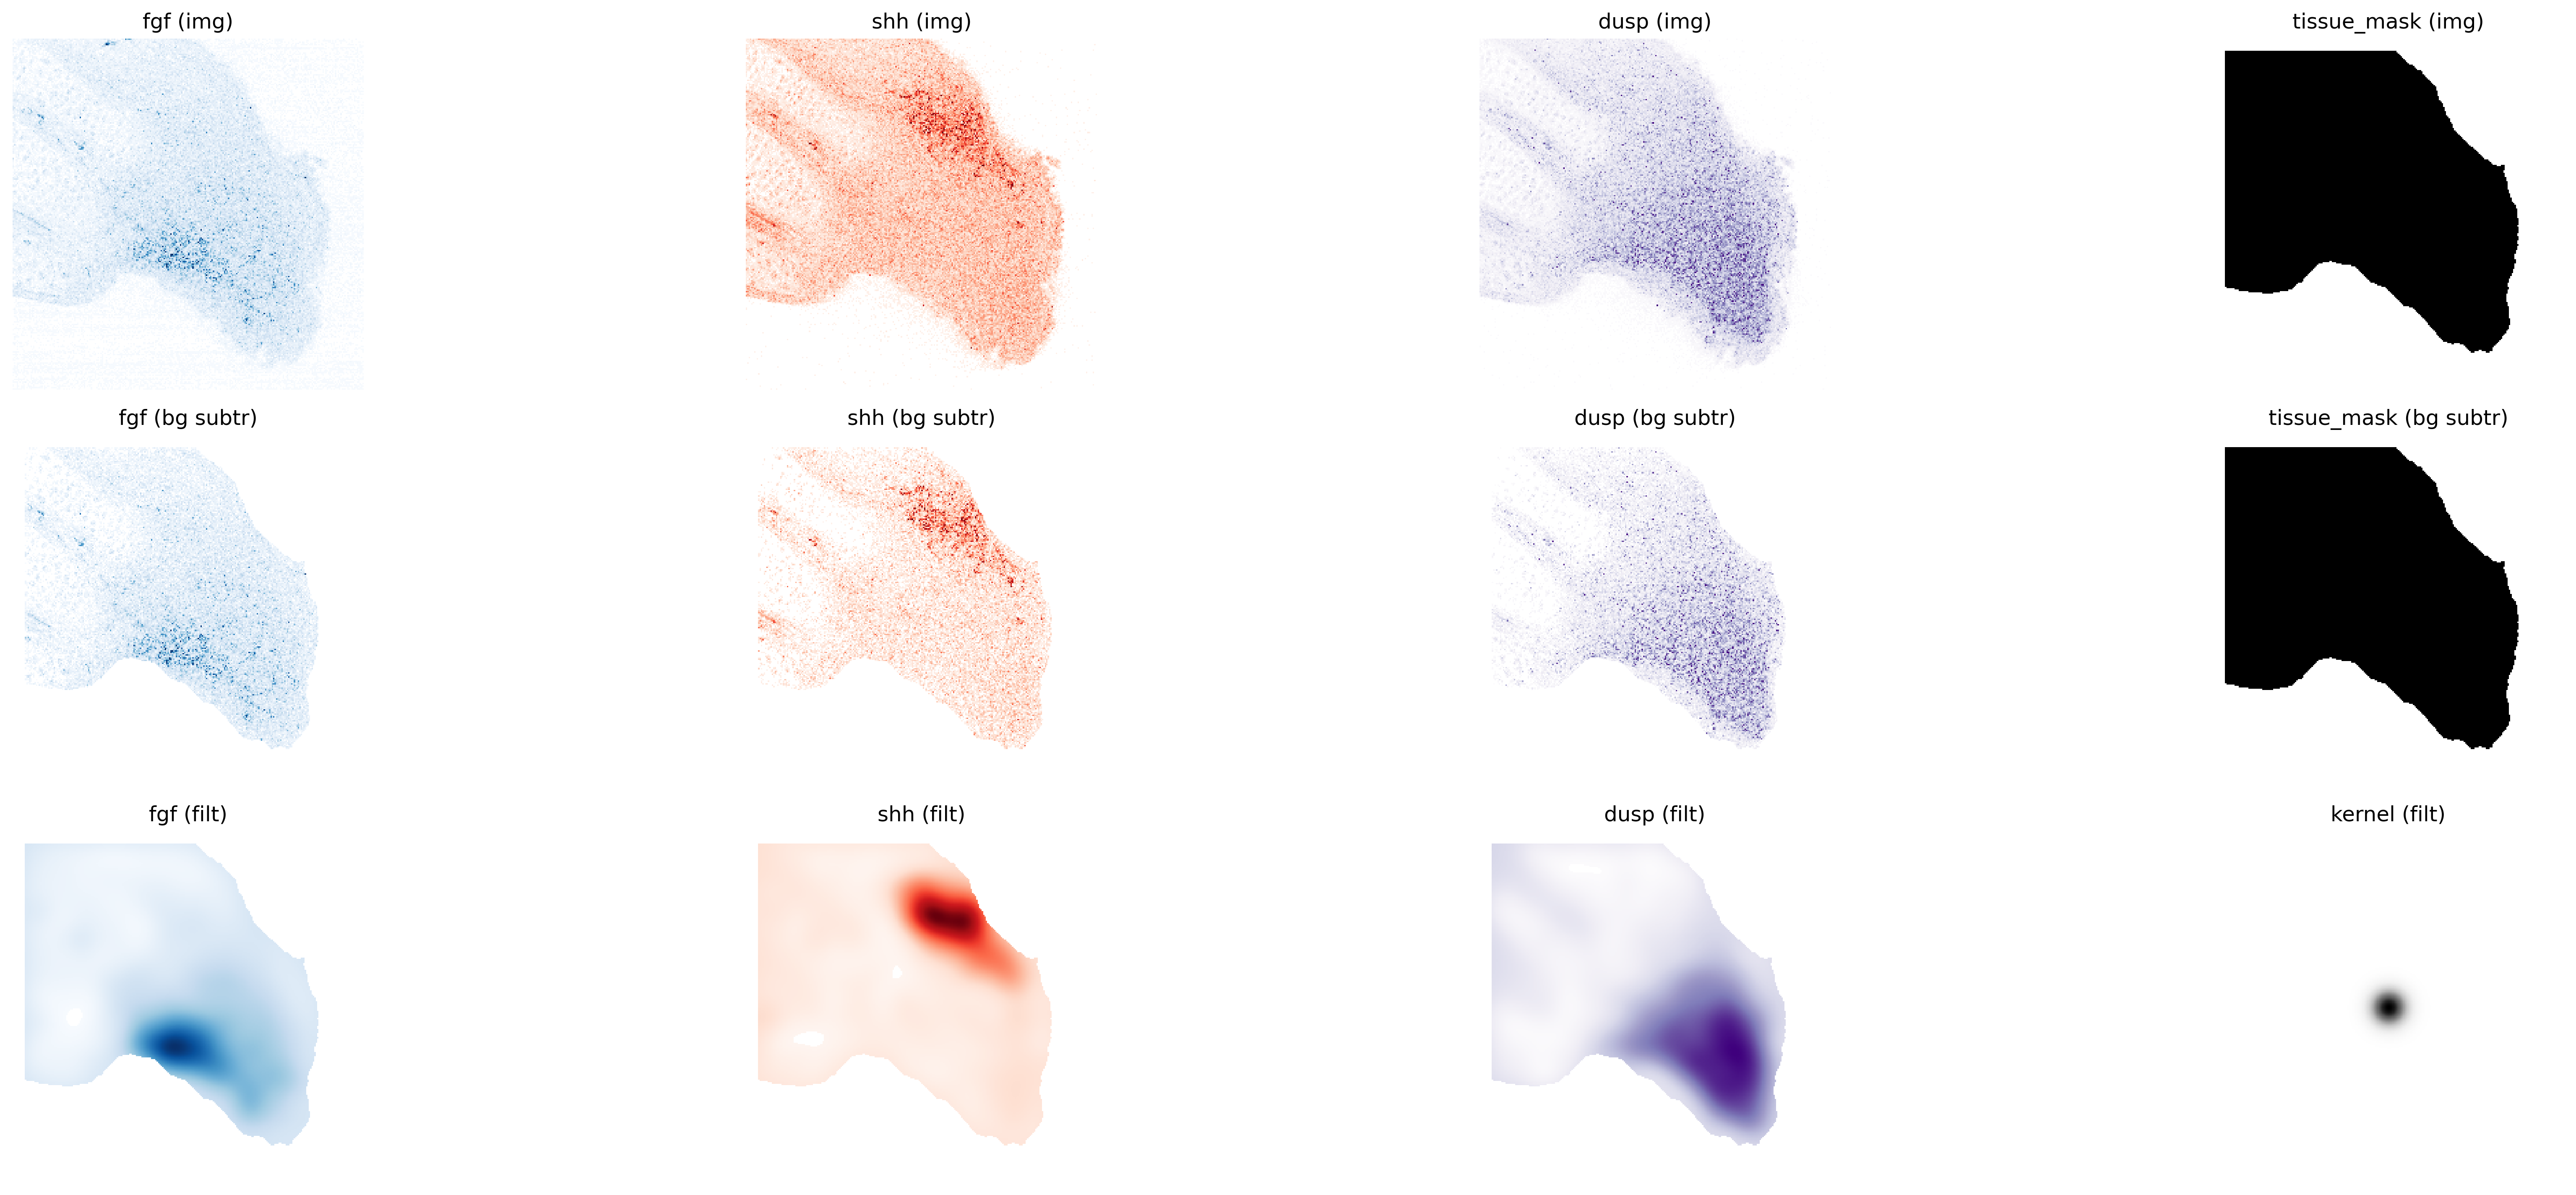

In [32]:
# Plotting
default_figsize = plt.rcParams["figure.figsize"]
ncols = len(img_plot)
fig, axes = plt.subplots(3, ncols, figsize=(default_figsize[0] * len(img_plot), 2*default_figsize[1]), dpi=300)

# Ensure axes is always 2D array
axes = np.array(axes).reshape(3, ncols)

# row: 1
for col, key in enumerate(img_plot):
    ax = axes[0, col]
    ax.imshow(2 * img_plot[key], cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(f'{key} (img)')
    ax.axis('off')

# row: 2
for col, key in enumerate(img_wo_bg):
    ax = axes[1, col]
    ax.imshow(2 * img_wo_bg[key], cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(f'{key} (bg subtr)')
    ax.axis('off')

# row: 3
for col, key in enumerate(img_filt):
    ax = axes[2, col]
    ax.imshow(2 * img_filt[key], cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(f'{key} (filt)')
    ax.axis('off')

plt.tight_layout()
#plt.savefig('fig/pipeline.pdf')
plt.show()

In [33]:
sigma

9.019

# Isolines

In [34]:
from matplotlib.colors import Normalize

def plot_colored_percentile_isolines(ax, image, n_levels=10, cmap='turbo'):
    
    image = np.asarray(image)
    image_flat = image[~np.isnan(image)]
    vmin, vmax = np.min(image_flat), np.max(image_flat)

    # Percentile levels (excluding 0% and 100%)
    levels = np.linspace(vmin, vmax, n_levels + 1)[1:-1]
    norm = Normalize(vmin=vmin, vmax=vmax)
    colormap = plt.get_cmap(cmap)

    for level in levels * levels:
        if np.isclose(level, (vmin + vmax) / 2, atol=(vmax - vmin) / (n_levels * 2)):
            # 50% isoline (center level)
            ax.contour(image, levels=[level], colors='black', linewidths=2.5, extent=extent)

        color = colormap(norm(level))
        ax.contour(image, levels=[level], colors=[color], linewidths=1.2, extent=extent)

    return levels, colormap, norm

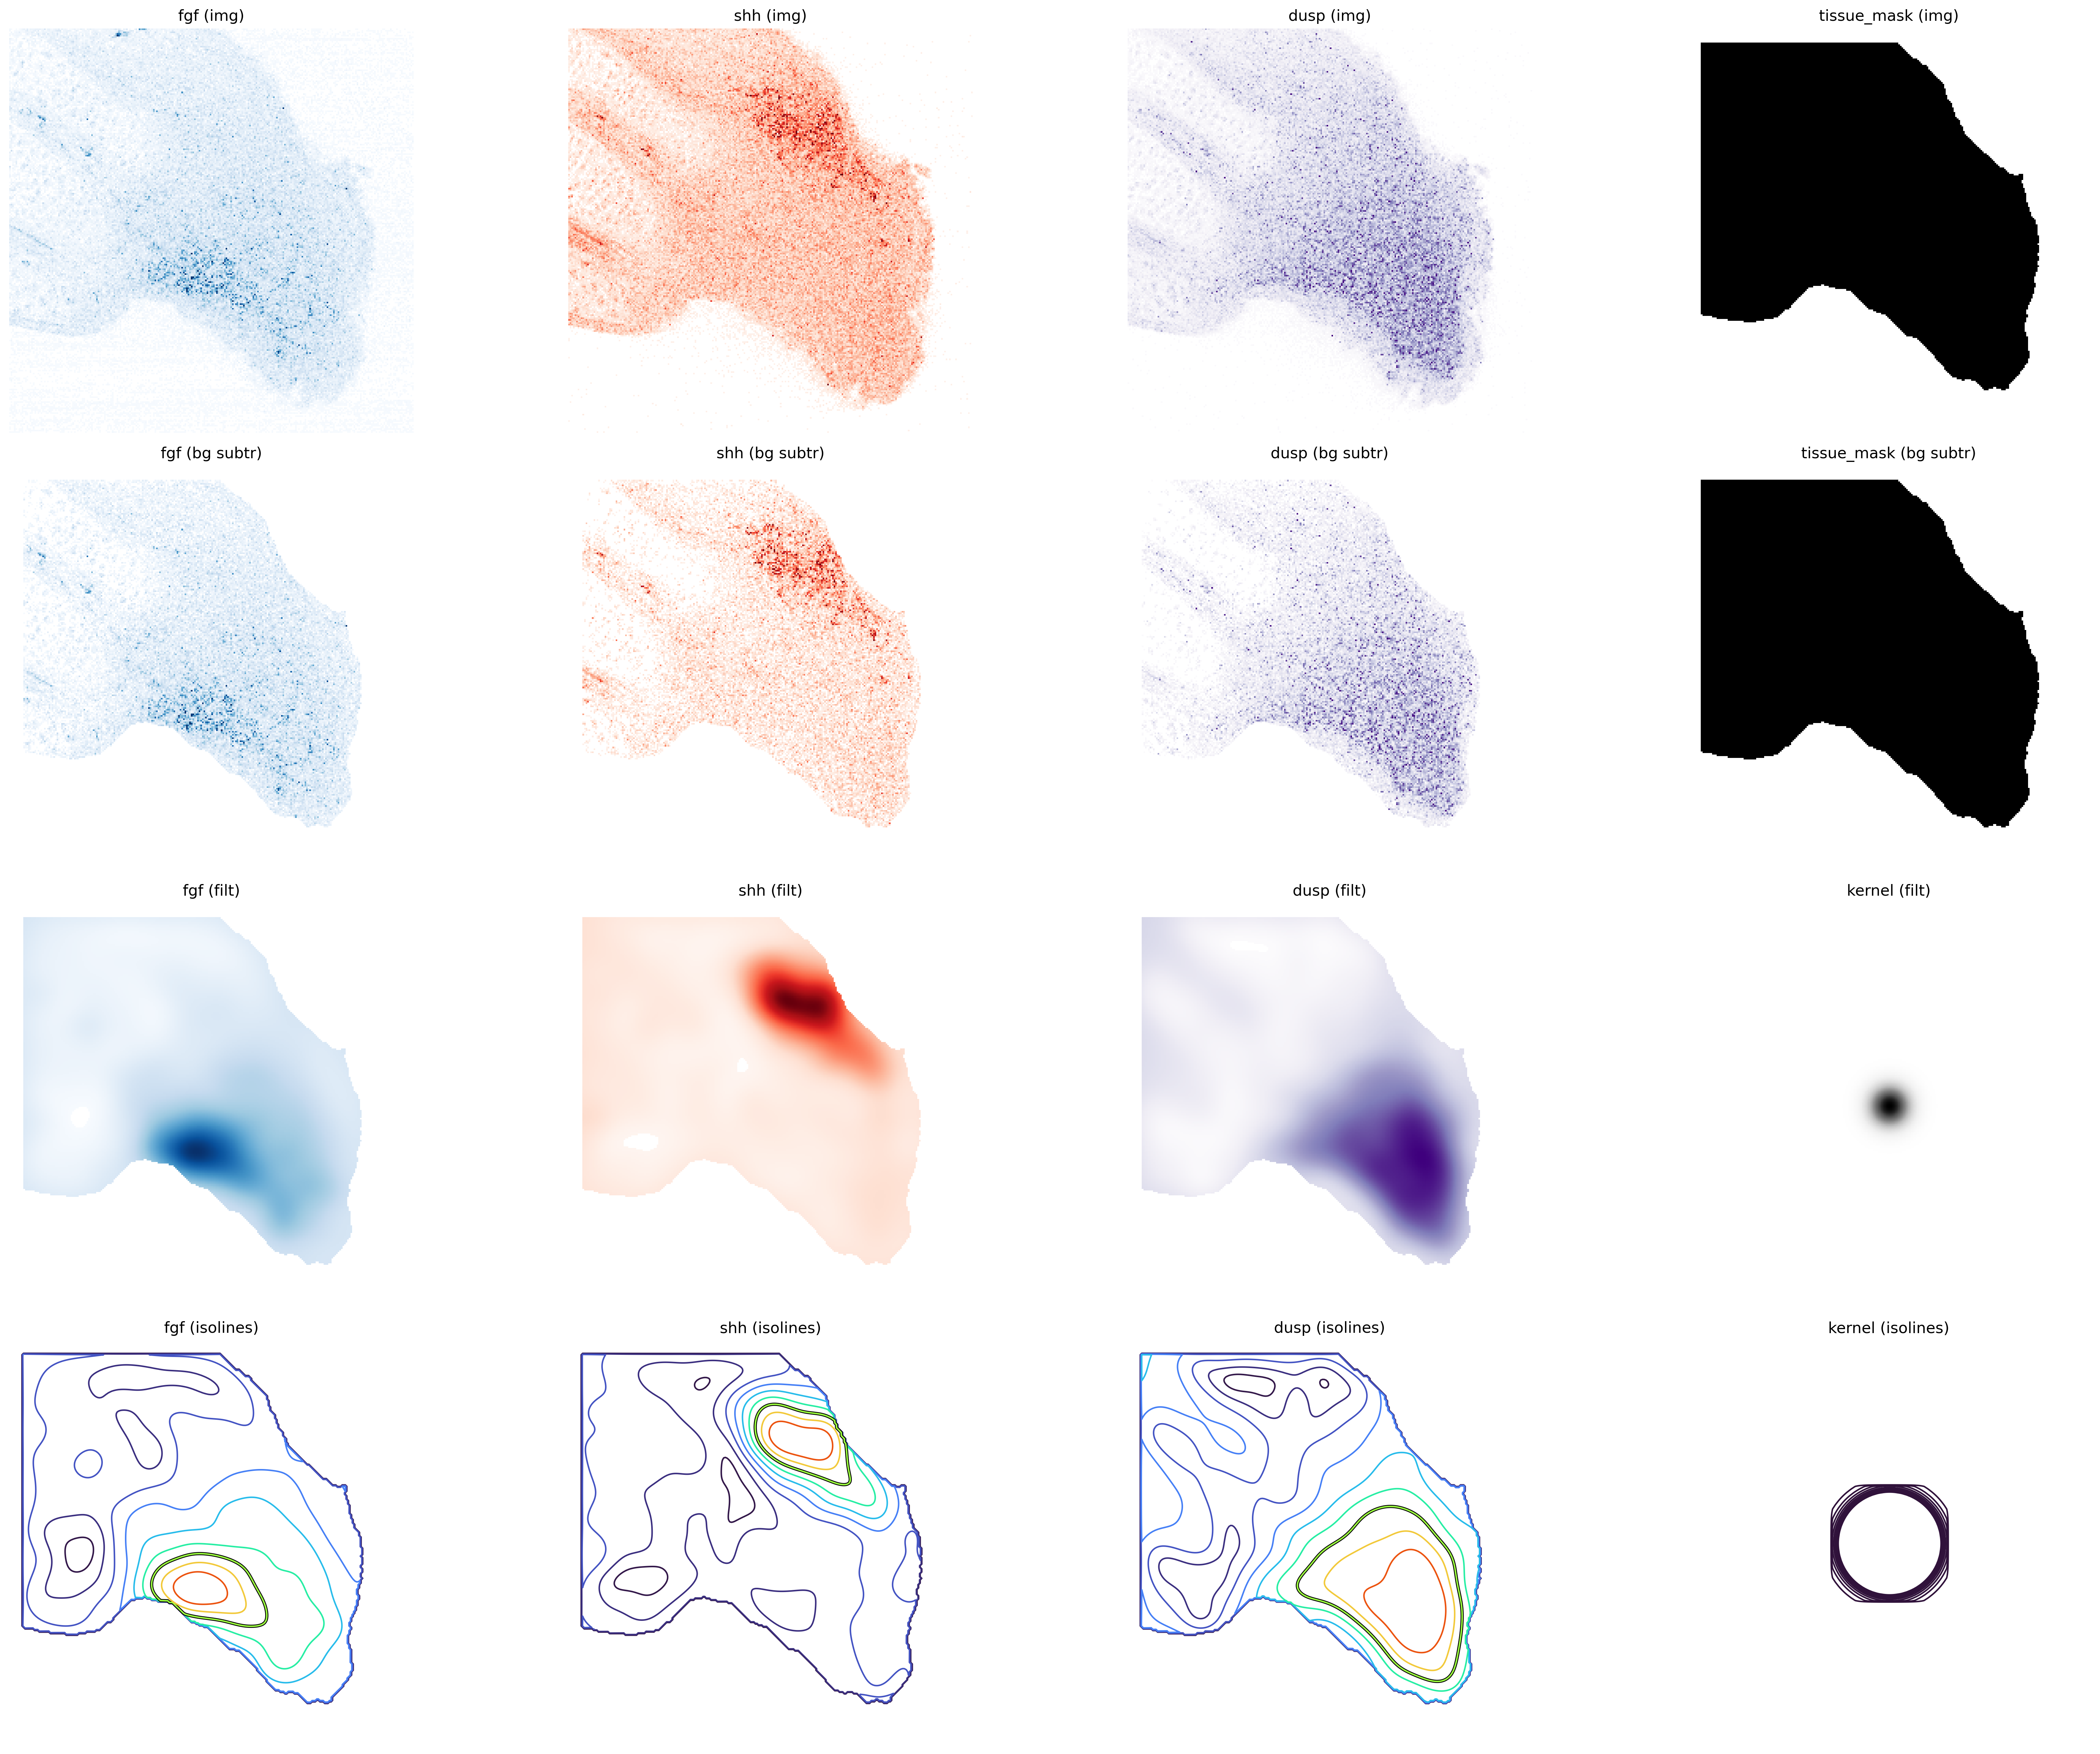

In [35]:
# Plotting
default_figsize = plt.rcParams["figure.figsize"]
ncols = len(img_plot)

nrows = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(default_figsize[0] * len(img_plot), nrows*default_figsize[1]), dpi=300)

# Ensure axes is always 2D array
axes = np.array(axes).reshape(nrows, ncols)

# row: 1
for col, key in enumerate(img_plot):
    ax = axes[0, col]
    ax.imshow(2 * img_plot[key], cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(f'{key} (img)')
    ax.axis('off')
    ax.set_aspect('equal')

# row: 2
for col, key in enumerate(img_wo_bg):
    ax = axes[1, col]
    ax.imshow(2 * img_wo_bg[key], cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(f'{key} (bg subtr)')
    ax.axis('off')
    ax.set_aspect('equal')

# row: 3
for col, key in enumerate(img_filt):
    ax = axes[2, col]
    ax.imshow(2 * img_filt[key], cmap=color_map.get(key, 'gray'), extent=extent)
    ax.set_title(f'{key} (filt)')
    ax.axis('off')
    ax.set_aspect('equal')

# row: 3
for col, key in enumerate(img_filt):
    ax = axes[3, col]
    plot_colored_percentile_isolines(ax, img_filt[key], n_levels=10)
    ax.set_title(f'{key} (isolines)')
    ax.axis('off')
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('fig/pipeline.pdf')
plt.show()

In [36]:
from matplotlib.cm import ScalarMappable

def save_colorbar_for_isolines(image, cmap='seismic', n_levels=10, filename='colorbar.pdf', label='Intensity (%)'):

    image = np.asarray(image)
    image_flat = image[~np.isnan(image)]
    vmin, vmax = np.min(image_flat), np.max(image_flat)

    # Same levels as in the plotting function
    levels = np.linspace(vmin, vmax, n_levels + 1)[1:-1]
    percent_ticks = np.linspace(0, 100, n_levels + 1)[1:-1]  # match levels

    norm = Normalize(vmin=vmin, vmax=vmax)
    colormap = plt.get_cmap(cmap)

    fig, ax = plt.subplots(figsize=(1.0, 4))
    sm = ScalarMappable(norm=norm, cmap=colormap)
    sm.set_array([])

    cbar = fig.colorbar(sm, cax=ax, ticks=levels)
    cbar.ax.set_yticklabels([f"{int(p)}%" for p in percent_ticks])
    cbar.set_label(label)

    plt.tight_layout()
    plt.savefig(filename, dpi=300)

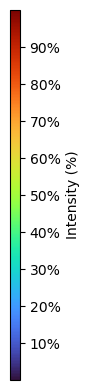

In [37]:
save_colorbar_for_isolines(image, cmap='turbo', n_levels=10, filename='colorbar_isolines.pdf')